In [3]:
import numpy as np  # the Python array package
import matplotlib.pyplot as plt
import nibabel as nib

# Show figures inside the notebook
%matplotlib inline

In [5]:
img = nib.load('data/ds114_sub009_t2r1.nii')
type(img)

nibabel.nifti1.Nifti1Image

Because images can have large arrays, nibabel does not load the image array when you load the image, in order to save time and memory. The best way to get the image array data is with the get_data() method.

In [6]:
data = img.get_data()
type(data)

numpy.core.memmap.memmap

The memmap is a special type of array that saves memory, but otherwise behaves the same as any normal array.
<br>
We can disable the use of the 'memmap' special arrays by using the mmap keyword argument when you load the image.

In [7]:
img = nib.load('data/ds114_sub009_t2r1.nii', mmap=False)

In [8]:
data = img.get_data()
type(data)

numpy.ndarray

### Four dimensional arrays - space + time

The image we have just loaded is a four-dimensional image, with a four-dimensional array:

In [9]:
data.shape

(64, 64, 30, 173)

The first three axes represent three dimensional space. The last axis represents time. Here the last (time) axis has length 173. This means that, for each of these 173 elements, there is one whole three dimensional image. We often call the three-dimensional images volumes. So we could say that this 4D image contains 173 volumes.
<br><br>
We have previously been taking slices over the third axis of a three-dimensional image. We can now take slices over the fourth axis of this four-dimensional image:


In [10]:
first_vol = data[:, :, :, 0]  # A slice over the final (time) axis

In [11]:
first_vol.shape

(64, 64, 30)

You can use the ellipsis `...` when slicing an array.  The ellipsis is a short cut for "everything on the previous axes".  For example, these two have exactly the same meaning:

In [12]:
first_vol = data[:, :, :, 0]
first_vol_again = data[..., 0]  # Using the ellipsis

In [13]:
first_vol.shape

(64, 64, 30)

`first_vol` is a 3D image just like the 3D images with. We plot the slice number 14:

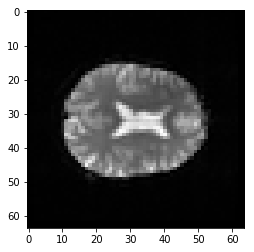

In [14]:
plt.imshow(first_vol[:, :, 14], cmap='gray')  # A slice over the third dimension

### Numpy operations work on the whole array by default

Numpy operatons like `min`, and `max` and `std` operate on the whole numpy array by default, ignoring any array shape. For example, here is the maximum value for the whole 4D array:

In [15]:
np.max(data)

6793

This is exactly the same as:

In [16]:
np.max(data.ravel())  # maximum when flattening the array to 1 dimension

6793

You can ask numpy to operate over particular axes instead of operating over the whole array. For example, this will generate a 3D image, where each array value is the variance the 173 values at that 3D position (the variance across time):

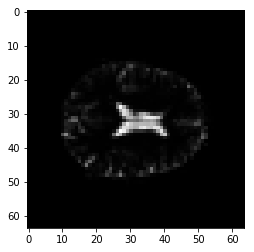

In [21]:
var_vol = np.var(data, axis=3)  # variance across the final (time) axis
plt.imshow(var_vol[:, :, 14], cmap='gray')

Select the 10th volume (time index 9) from 4D image data array, by slicing over the last dimension. What shape is it?

In [22]:
# Get the 10th volume and show shape
tenth_vol = data[..., 9]
tenth_vol.shape

(64, 64, 30)

### Get the standard deviation across all voxels in this 3D volume:

In [23]:
# Standard deviation across all voxels for 10th volume
np.std(tenth_vol)

630.442744399518

Loop over all volumes in the 4D image and store the standard deviation for each volume in a list. Plot these to see if there are any volumes with particularly unusual standard deviation.

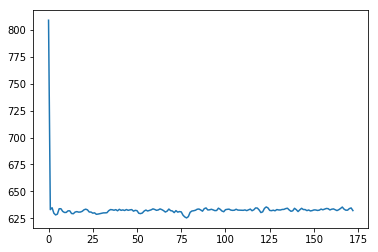

In [24]:
# Get standard deviation for each volume; then plot the values
stds = []
for i in range(data.shape[-1]):
    vol = data[..., i]
    stds.append(np.std(vol))
plt.plot(stds)

SPM uses a measure called "global signal" to give a very rough estimate of the average signal value within the brain.  The idea is that you need a threshold to select voxels with signal high enough to be inside the brain, and not in the air around the brain, which has very low (near 0) signal.

The algorithm goes like this.

* Get a single 3D volume V;
* Calculate the mean signal of the voxels in V; call that M;
* Make a threshold T where T = M / 8.
* Select all voxel values in V that are greater than T; call these values W;
* Return the mean of all values in W.

Let's say I have a function that loads a 4D image, and a list with mean values across all voxels in each volume:

In [25]:
def vol_means(image_fname):
    img = nib.load(image_fname)
    data = img.get_data()
    means = []
    for i in range(data.shape[-1]):
        vol = data[..., i]
        means.append(np.mean(vol))
    return means

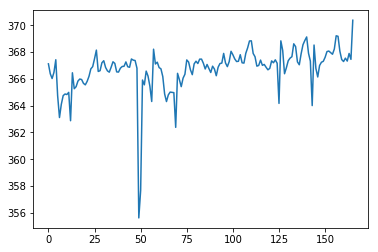

In [28]:
my_means = vol_means('data/ds107_sub012_t1r2.nii')
plt.plot(my_means)

## SPM Function

In [29]:
def spm_global(vol):
    T = np.mean(vol) / 8
    return np.mean(vol[vol > T])


def get_spm_globals(fname):
    img = nib.load(fname)
    data = img.get_data()
    spm_vals = []
    for i in range(data.shape[-1]):
        vol = data[..., i]
        spm_vals.append(spm_global(vol))
    return spm_vals

In [32]:
glob_vals = get_spm_globals('data/ds107_sub012_t1r2.nii')

print(np.mean(glob_vals))

376.3783119593711
